In [31]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys; sys.path.append("../")
from tqdm.auto import tqdm
from util import select_columns, plot_ESS, plot_GR
from numpyro.diagnostics import effective_sample_size, gelman_rubin

directory = "neals_funnel"
num_chains = 20
num_samples = 10000

dfs = {"no": {}, "full": {}, "half": {}, "auto": {}}

for name in tqdm(sorted(os.listdir(directory))):
    if ".csv" in name:
        split = name.strip(".csv").split("_")
        label = split[0]
        y = float(split[2])
        sigma = float(split[4])

        df = pd.read_csv(os.path.join(directory, name), usecols=lambda col: col != "draws")
        dfs[label][(y, sigma)] = df

dfs = {label: list(sorted(dfs[label].items())) for label in dfs}
dfs = {label: list(map(lambda x: x[1], dfs[label])) for label in dfs}

for label in dfs:
    for i, df in enumerate(dfs[label]):
        df.columns = [f'{col.split("[")[0]}[{i}]{col.split("]")[1]}' for col in df.columns]
    dfs[label] = pd.concat(dfs[label], axis=1)

  0%|          | 0/102 [00:00<?, ?it/s]

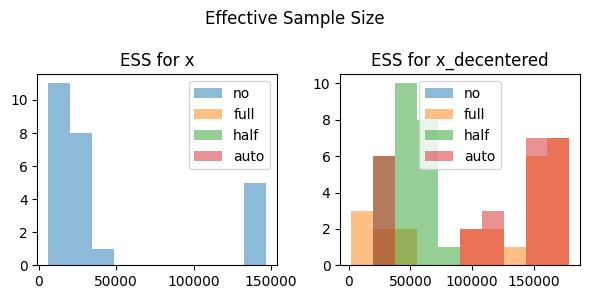

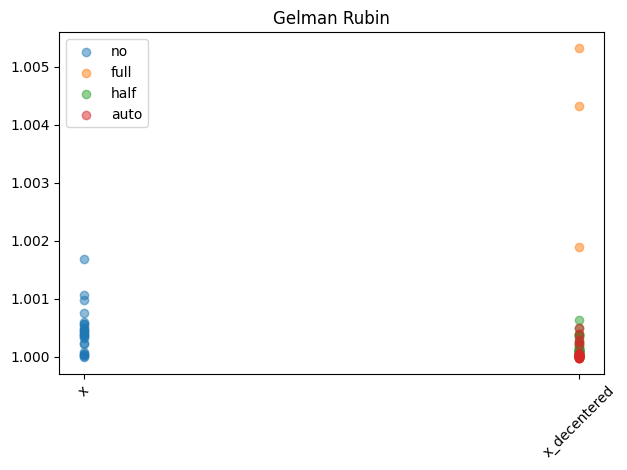

In [37]:
%matplotlib inline
labels = ["no", "full", "half", "auto"]
params = ["x", "x_decentered"]

plot_ESS(dfs.values(), labels, params, num_chains, num_samples)
plot_GR(dfs.values(), labels, params, num_chains, num_samples)

In [40]:
sample_1 = select_columns(dfs["no"], "x").to_numpy().reshape(num_chains, num_samples, -1)
sample_2 = select_columns(dfs["full"], "x_decentered").to_numpy().reshape(num_chains, num_samples, -1)
sample_3 = select_columns(dfs["half"], "x_decentered").to_numpy().reshape(num_chains, num_samples, -1)
sample_4 = select_columns(dfs["auto"], "x_decentered").to_numpy().reshape(num_chains, num_samples, -1)
samples = [sample_1, sample_2, sample_3, sample_4]

In [45]:
bound = 20
step = 5

y_hmc = torch.linspace(-bound, bound, step).round()
sigma_hmc = torch.linspace(0.1, bound, step).round()
y_hmc, sigma_hmc = map(torch.flatten, torch.meshgrid(y_hmc, sigma_hmc, indexing="ij"))

dfs = []
for sample, label in zip(samples, labels):
    df = pd.DataFrame({"y": y_hmc.flatten(), "sigma": sigma_hmc.flatten()})
    df["reparam"] = label
    df["ess"] = effective_sample_size(sample)
    df["gr"] = gelman_rubin(sample)
    dfs.append(df)

df_hmc = pd.concat(dfs, axis=0)
df_hmc

,y,sigma,reparam,ess,gr
0,-20.0,0.0,no,139331.084926,1.000006
1,-20.0,5.0,no,6674.358732,1.001076
2,-20.0,10.0,no,14525.730995,1.000575
3,-20.0,15.0,no,17732.134644,1.000453
4,-20.0,20.0,no,18021.365889,1.000597
...,...,...,...,...,...
20,20.0,0.0,auto,24060.656186,1.000254
21,20.0,5.0,auto,32224.420502,1.000066
22,20.0,10.0,auto,118473.543751,1.000025
23,20.0,15.0,auto,152683.235156,0.999994


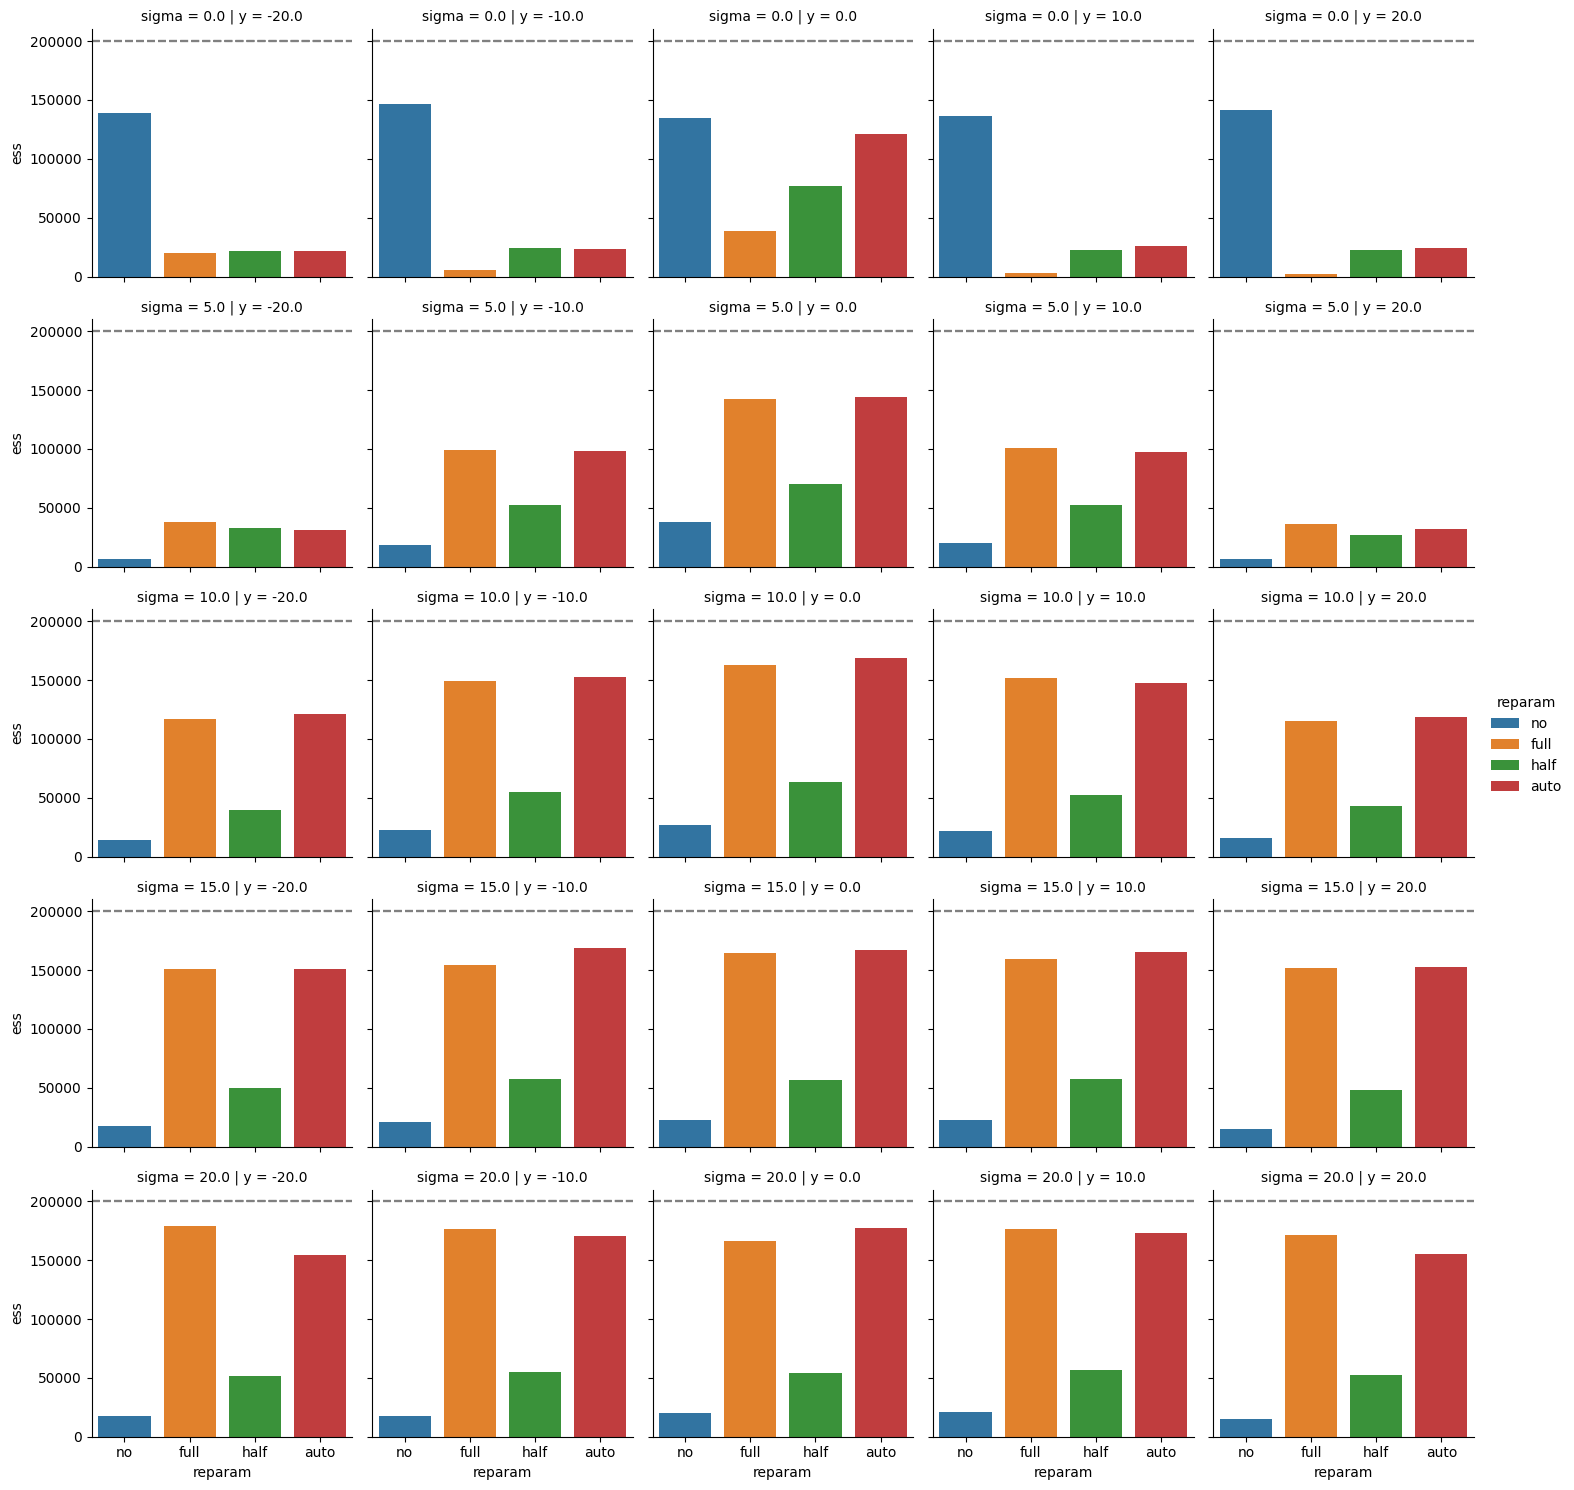

In [61]:
%matplotlib inline
order = df_hmc.reparam.unique()
g = sns.FacetGrid(df_hmc, col="y", row="sigma", hue="reparam")
g.map(sns.barplot, "reparam", "ess", order=order)
g.refline(y=num_chains * num_samples)
g.add_legend()
plt.savefig(os.path.join(directory, "ess.pdf"))

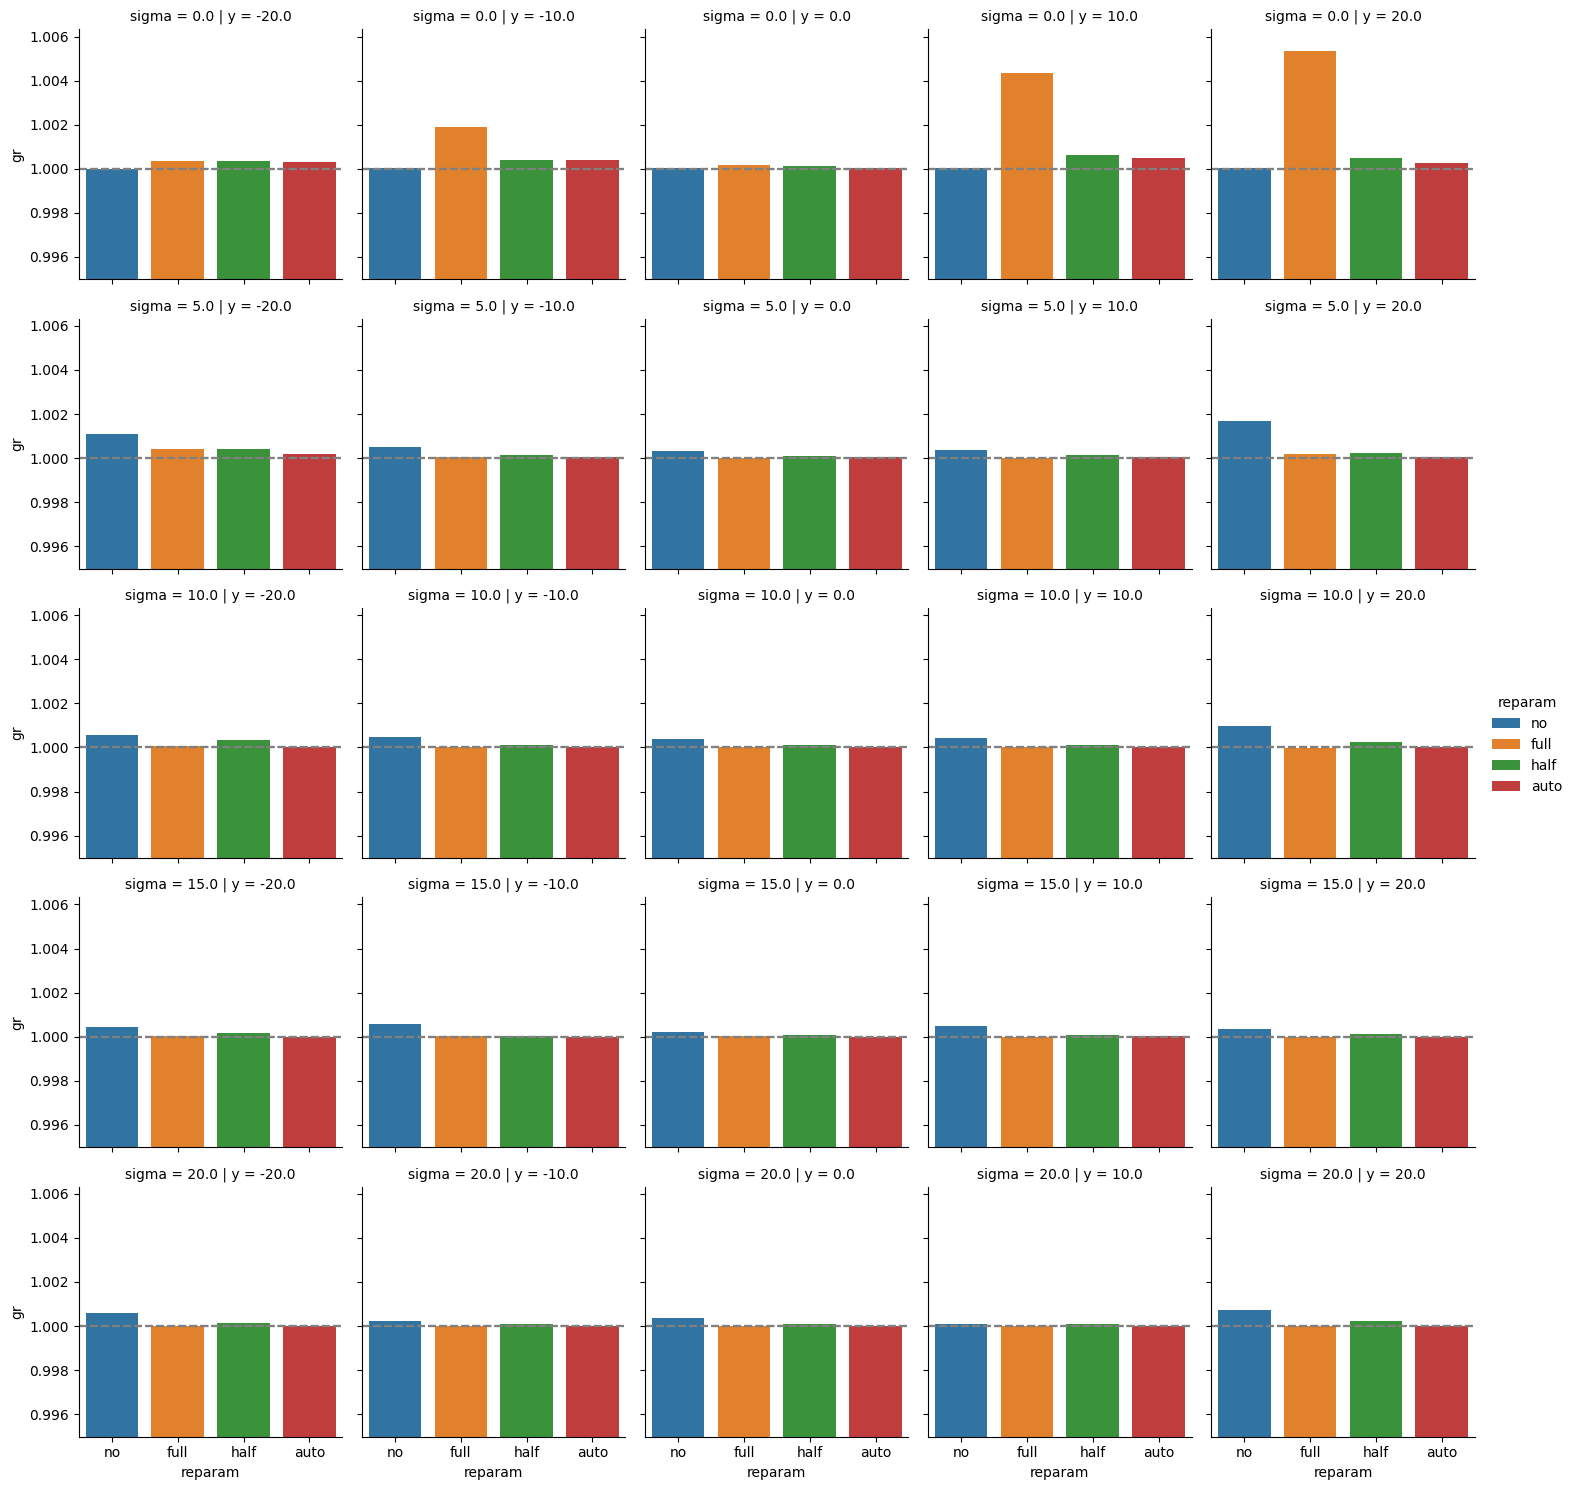

In [62]:
%matplotlib inline
order = df_hmc.reparam.unique()
g = sns.FacetGrid(df_hmc, col="y", row="sigma", hue="reparam")
g.map(sns.barplot, "reparam", "gr", order=order)
g.set(ylim=(df_hmc["gr"].min() - 5e-3, df_hmc["gr"].max() + 1e-3))
g.refline(y=1)
g.add_legend()
plt.savefig(os.path.join(directory, "gr.pdf"))